In [2]:
import torch
import torchvision
from tqdm import tqdm
import numpy as np
from unet import UNet
from torch.utils.data import DataLoader
import os
import sys
from train import evaluate
import matplotlib.pyplot as plt

SCRIPT_DIR = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from dataset import PanDataset

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

train_perc = 0.8
batch_size = 4
num_workers = 4

model_path = "../models/unet/unet.pth"
path_to_data = "../data/"
path_to_data = path_to_data + "SOTA/"

if "SOTA" not in path_to_data:
    path_to_val = os.path.join(path_to_data, "val")

    path_to_val_pan = os.path.join(path_to_val, "pan")
    path_to_val_rgb = os.path.join(path_to_val, "rgb")
    path_to_val_sharp = os.path.join(path_to_val, "sharp")

else:
    path_to_val_pan = os.path.join(path_to_data, "pan")
    path_to_val_rgb = os.path.join(path_to_data, "rgb")
    path_to_val_sharp = os.path.join(path_to_data, "sharp")

In [8]:
unet = UNet(n_channels=4, n_classes=3).cuda()
weights = torch.load(model_path)
unet.load_state_dict(weights)

val_data = PanDataset(path_to_pan=path_to_val_pan, path_to_rgb=path_to_val_rgb, path_to_sharp=path_to_val_sharp, train_perc=1 - train_perc, train=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

criterion = torch.nn.MSELoss()

val_loss = evaluate(net=unet, val_loader=val_loader, criterion=criterion)
print(f'validation loss: {val_loss}')

validation loss: 6.471201550221076e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


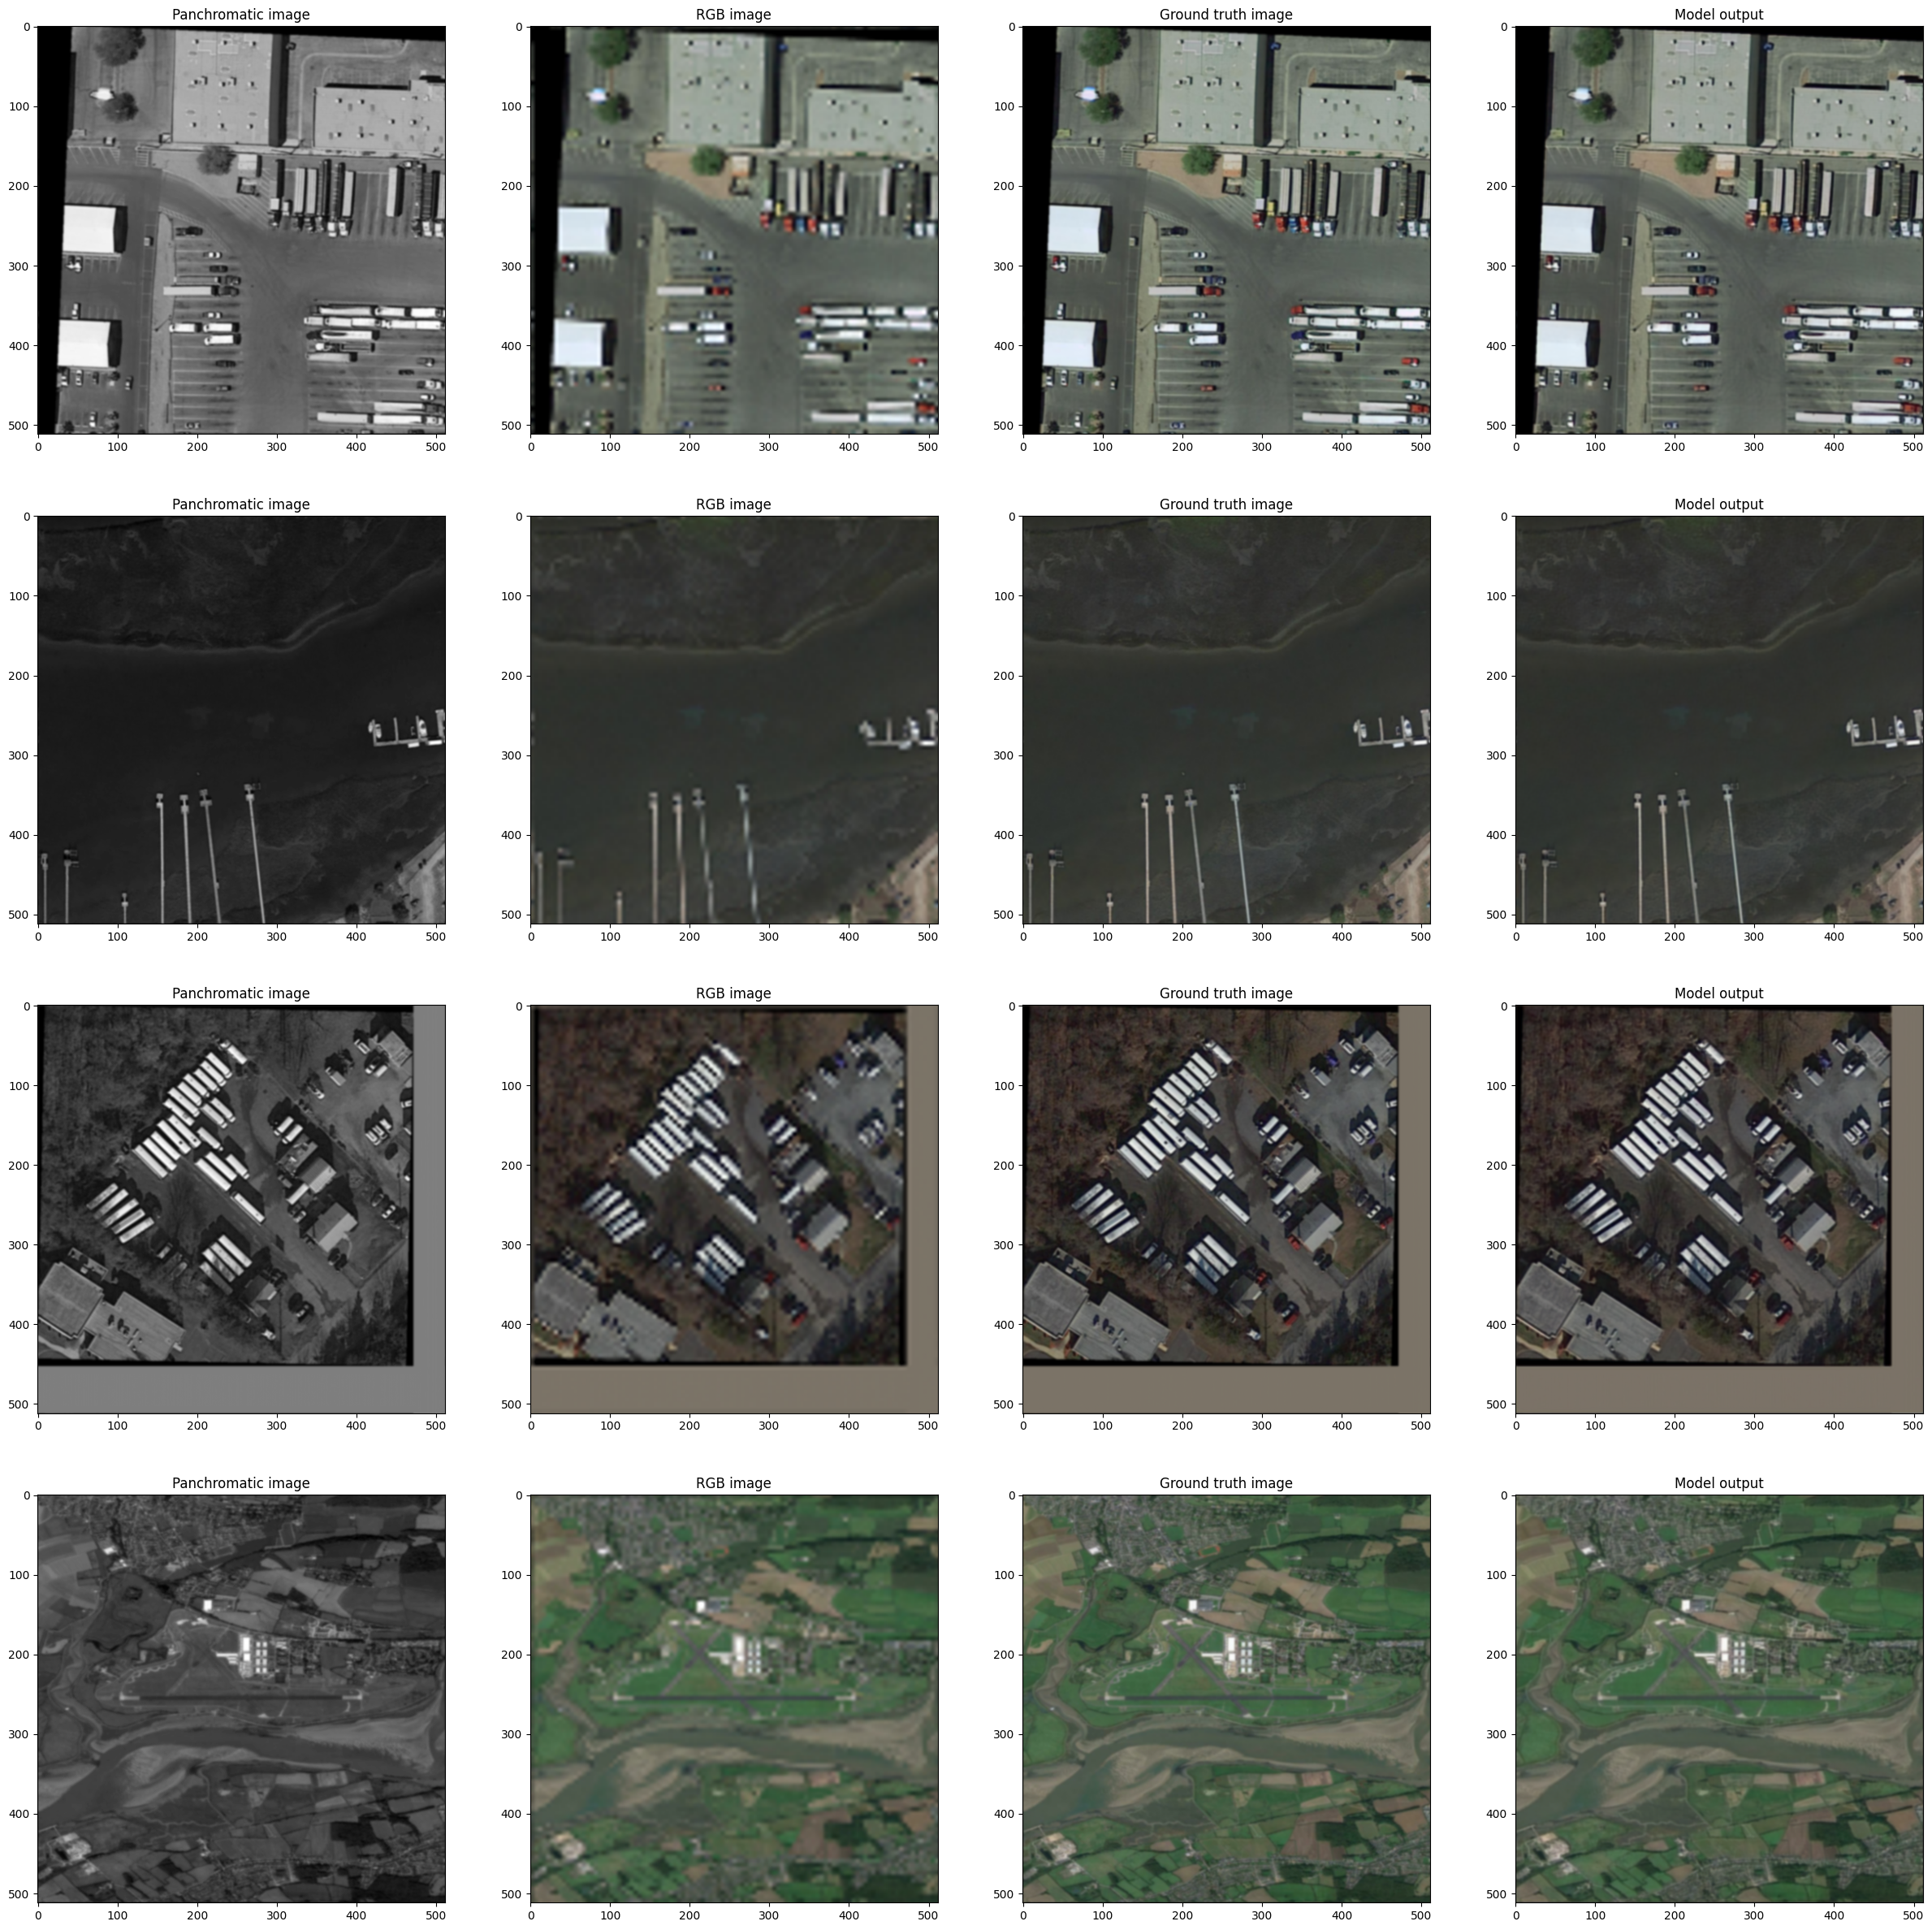

In [22]:
plt.figure(figsize=(30, 30))

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = unet(x)
        x, y, outputs = x.to("cpu").numpy(), y.to("cpu").numpy(), outputs.to("cpu").numpy()
        
        i = 0
        for input_imgs, sharp, output in zip(x, y, outputs):
            
            input_imgs = input_imgs.transpose((1, 2, 0))
            sharp = sharp.transpose((1, 2, 0))
            output = output.transpose((1, 2, 0))
            

            pan = input_imgs[:, :, 0]
            rgb = input_imgs[:, :, 1:]
    
            plt.subplot(batch_size, 4, i + 1)
            plt.imshow(pan, cmap="gray")
            plt.title("Panchromatic image")

            plt.subplot(batch_size, 4, i + 2)
            plt.imshow(rgb)
            plt.title("RGB image")

            plt.subplot(batch_size, 4, i + 3)
            plt.imshow(sharp)
            plt.title("Ground truth image")

            plt.subplot(batch_size, 4, i + 4)
            plt.imshow(output)
            plt.title("Model output")

            i += 4
        
        break